In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns;  #makes graph colors pretty
from gensim.summarization import keywords
from __future__ import print_function
import os
import re
import string
import pandas as pd
import numpy as np
import keras
sns.set()
sns.palplot(sns.color_palette("muted"))


%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))



Using TensorFlow backend.


stage2_test_text.csv
stage2_test_variants.csv
test_text
test_variants
training_text
training_variants



In [2]:
train_var = pd.read_csv("../input/training_variants")
test_var = pd.read_csv("../input/test_variants")
train_text = pd.read_csv("../input/training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text = pd.read_csv("../input/test_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
#dataframe.shape returns a tuple representing dimensionality
print("Train and Test variants shape : ",train_var.shape, test_var.shape)
print("Train and Test text shape : ",train_text.shape, test_text.shape)

Train and Test variants shape :  (3321, 4) (5668, 3)
Train and Test text shape :  (3321, 2) (5668, 2)


In [3]:
#dataframe.head returns first 5 rows
#training variants
train_var.head()
train_var.describe(include='all')

,ID,Gene,Variation,Class
count,3321.000000,3321,3321,3321.000000
unique,NaN,264,2996,NaN
top,NaN,BRCA1,Truncating Mutations,NaN
freq,NaN,264,93,NaN
mean,1660.000000,NaN,NaN,4.365854
std,958.834449,NaN,NaN,2.309781
min,0.000000,NaN,NaN,1.000000
25%,830.000000,NaN,NaN,2.000000
50%,1660.000000,NaN,NaN,4.000000
75%,2490.000000,NaN,NaN,7.000000


In [4]:
#returns first 5 rows of training text
train_text.head()
train_text.describe(include='all')

,ID,Text
count,3321.000000,3316
unique,NaN,1920
top,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,53
mean,1660.000000,NaN
std,958.834449,NaN
min,0.000000,NaN
25%,830.000000,NaN
50%,1660.000000,NaN
75%,2490.000000,NaN


In [5]:
# train_data = pd.concat([train_var_df.set_index('ID'),
#                         train_text_df.set_index('ID')],axis=1)
train_data = pd.merge(train_var, train_text, how='left',on = 'ID').fillna('')
train_data['ID'] = train_data.ID.astype(int)
train_y = train_data['Class'].values
train_x = train_data.drop('Class',axis=1)
train_size=len(train_x)
train_data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
train_data.describe(include='all')

,ID,Gene,Variation,Class,Text
count,3321.000000,3321,3321,3321.000000,3321
unique,NaN,264,2996,NaN,1921
top,NaN,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


In [7]:
#dataframe.head returns first 5 rows
#test variants
test_var.head()

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


In [8]:
#returns first 5 rows of test text
test_text.head()

,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [9]:
# test_data = pd.concat([test_var_df.set_index('ID'),
#                         test_text_df.set_index('ID')],axis=1)
test_data = pd.merge(test_var, test_text, how='left',on = 'ID').fillna('')
test_data['ID'] = test_data.ID.astype(int)
test_data.head()

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


In [10]:
test_data.describe(include='all')

,ID,Gene,Variation,Text
count,5668.000000,5668,5668,5668
unique,NaN,1397,5628,5611
top,NaN,F8,Truncating Mutations,Mutations in BRCA1 and BRCA2 account for the m...
freq,NaN,134,18,6
mean,2833.500000,NaN,NaN,NaN
std,1636.354994,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,1416.750000,NaN,NaN,NaN
50%,2833.500000,NaN,NaN,NaN
75%,4250.250000,NaN,NaN,NaN


In [11]:
#print 1st row from training text dataframe
with open("../input/training_text") as infile:
    for i in range(0,2):
        line = infile.readline()
        print(line)

ID,Text

0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing pheno

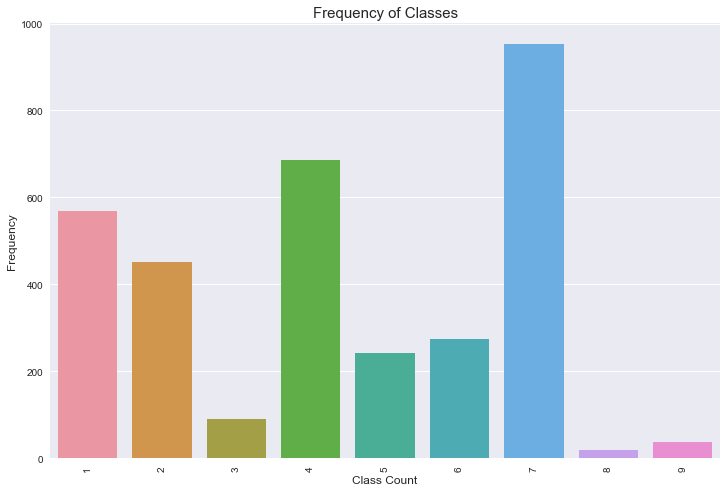

In [12]:
#frequenct of classes in training data
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=train_var)
plt.xlabel('Class Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Classes", fontsize=15)
plt.show()

In [13]:
#First column is Class
#Second column is Frequency
#All in training variants file
data=train_var
data["Class"].value_counts()      

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

In [14]:
#print(train_data)
train_data['Variation'].describe()

count                     3321
unique                    2996
top       Truncating Mutations
freq                        93
Name: Variation, dtype: object

In [15]:
#drop columns gene and variation
#print(train_data)
#train_data.drop(['Gene', 'Variation'], axis=1, inplace=True)


In [16]:
#https://rare-technologies.com/text-summarization-with-gensim/
from gensim.summarization import summarize
data_id = 0
#strictly gets the text from id 0
text = train_data.loc[data_id,'Text']
#print(text)
print ('Summary:')
#could set a limit on how many words to return etc.
print (summarize(text,split=True))

Summary:
['Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells.', 'Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations.', 'ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels.', 'They also shed light on the molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1).', 'The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2).', 'CDK10 knockdown 

In [17]:
# #algorithm tries to find words that are important 
# #or seem representative of the entire text
# from gensim.summarization import keywords
# #lemmatisation determines the lemma of a word 
# #based on its intended meaning
# trigger_words = keywords(text,words = 5,scores=True,lemmatize=True, split=True)
# print ("Keywords:")
# trigger_words =', '.join(['{}-{:.2f}'.format(i, j) for i, j in trigger_words])
# print ("["+trigger_words+"]")





In [18]:
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import stopwords
# from string import punctuation
# from scipy.misc import imresize
# from PIL import Image
# from wordcloud import WordCloud, ImageColorGenerator
# from collections import Counter

# custom_words = ["fig", "figure", "et", "al", "al.", "also",
#                 "data", "analyze", "study", "table", "using",
#                 "method", "result", "conclusion", "author", 
#                 "find", "found", "show", '"', "’", "“", "”"]

# stop_words = set(stopwords.words('english') + list(punctuation) + custom_words)
# wordnet_lemmatizer = WordNetLemmatizer()

# class_corpus = train_data.groupby('Class').apply(lambda x: x['Text'].str.cat())
# class_corpus = class_corpus.apply(lambda x: Counter(
#     [wordnet_lemmatizer.lemmatize(w) 
#      for w in word_tokenize(x) 
#      if w.lower() not in stop_words and not w.isdigit()]
# ))

In [19]:
test_index = test_data['ID'].values
all_data = np.concatenate((train_x, test_data), axis=0)
all_data = pd.DataFrame(all_data)
all_data.columns = ["ID", "Gene", "Variation", "Text"]
all_data['ID'] = all_data.ID.astype(int)
print (all_data.dtypes)
all_data.head()

ID            int64
Gene         object
Variation    object
Text         object
dtype: object


,ID,Gene,Variation,Text
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...


In [20]:
#figure out why there are nan objects?

In [21]:
#https://dunkley.me/blog/msk-redefining-cancer-treatment

#did not lemmatize words use Spacy lemmatizer
from nltk.corpus import stopwords
from gensim.models.doc2vec import TaggedDocument
from gensim import utils
import gensim

def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(TaggedDocument(gensim.utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

def textClean(text):
    #only including alphanumeric symbols
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]  
    text = " ".join(text)
    return(text)
    
def cleanup(text):
    text = textClean(text)
    #gets rid of punctiations
    text= text.translate(str.maketrans("","", string.punctuation))
    return text

# all_data = all_data['Text'].str.decode("utf8")
#all_data['Text'] = all_data.Text.astype(str)
print (all_data.dtypes)
#allText = textClean(str(all_data['Text'])
allText = all_data['Text'].apply(cleanup)
#sentences = constructLabeledSentences(allText)
allText.head()


ID            int64
Gene         object
Variation    object
Text         object
dtype: object


0    cyclindependent kinases cdks regulate variety ...
1    abstract background nonsmall cell lung cancer ...
2    abstract background nonsmall cell lung cancer ...
3    recent evidence demonstrated acquired uniparen...
4    oncogenic mutations monomeric casitas blineage...
Name: Text, dtype: object

In [22]:
# print(train_data.dtypes)
# newtext = train_data['Text'].apply(cleanup)
# newtext.head()

In [23]:
sentences = constructLabeledSentences(allText)
sentences[0]

TaggedDocument(words=['cyclindependent', 'kinases', 'cdks', 'regulate', 'variety', 'fundamental', 'cellular', 'processes', 'cdk10', 'stands', 'one', 'last', 'orphan', 'cdks', 'activating', 'cyclin', 'identified', 'kinase', 'activity', 'revealed', 'previous', 'work', 'shown', 'cdk10', 'silencing', 'increases', 'ets2', 'vets', 'erythroblastosis', 'virus', 'e26', 'oncogene', 'homolog', '2', 'driven', 'activation', 'mapk', 'pathway', 'confers', 'tamoxifen', 'resistance', 'breast', 'cancer', 'cells', 'precise', 'mechanisms', 'cdk10', 'modulates', 'ets2', 'activity', 'generally', 'functions', 'cdk10', 'remain', 'elusive', 'demonstrate', 'cdk10', 'cyclindependent', 'kinase', 'identifying', 'cyclin', 'activating', 'cyclin', 'cyclin', 'm', 'orphan', 'cyclin', 'product', 'fam58a', 'whose', 'mutations', 'cause', 'star', 'syndrome', 'human', 'developmental', 'anomaly', 'whose', 'features', 'include', 'toe', 'syndactyly', 'telecanthus', 'anogenital', 'renal', 'malformations', 'show', 'star', 'syndr

In [24]:
from gensim.models import Doc2Vec

Text_INPUT_DIM=300


text_model=None
filename='docEmbeddings_5_clean.d2v'
if os.path.isfile(filename):
    text_model = Doc2Vec.load(filename)
else:
    #doc2vec
    #workers is the number of threads
    #window 
    #using words you have to create to vectorize
    #have all words in model and 
    #use that model to create the array
    #window is distance between current and predicted word
    #sample the threshold for configuring which higher-frequency words are randomly downsampled, useful range is
    #negative specifies how many noise words should be drawn
    #epochs (int) – Number of iterations (epochs) over the corpus.
    text_model = Doc2Vec(min_count=1, window=5,vector_size=Text_INPUT_DIM, sample=1e-4, negative=5, workers=4, epochs=5,seed=1)
    text_model.build_vocab(sentences)
    text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.iter)
    text_model.save(filename)

In [25]:
test_size =(len(test_data))
text_train_arrays = np.zeros((train_size, Text_INPUT_DIM))
text_test_arrays = np.zeros((test_size, Text_INPUT_DIM))

#never train with test set so you split training data into 
#training and validaition sets

#vectorization of training text
for i in range(train_size):
    text_train_arrays[i] = text_model.docvecs['Text_'+str(i)]

j=0

#vectorizing test data
for i in range(train_size,train_size+test_size):
    text_test_arrays[j] = text_model.docvecs['Text_'+str(i)]
    j=j+1

#vector for each id
#3321 points in 300 dimensional space
#text_train_arrays[0] is first vector
#len(text_train_arrays[0]) = 300
# 3321 indices
#print("Size of text_train_arrays:")

print (len(text_train_arrays))
#print (len(text_train_arrays[0]))
print(text_train_arrays[0])
#print(text_train_arrays[0][:50])

3321
[ 0.73517305  0.11103367 -0.53674453 -0.49298826  1.75204885  0.56311238
  0.64693618  0.95128471 -0.94143909  0.10217472 -0.54952389  0.48968211
  0.33630639  0.73038578  0.11525199 -0.82236463 -0.09477141  0.45024166
  0.28787279 -0.07502058 -0.70974469  0.16556656 -0.26494232 -0.18229812
  0.12648657 -0.14647098  1.24078095  0.05696517  0.27502912  0.0952572
  0.72563267 -0.53188413  0.23955122  0.0699062   0.26262894  1.13780475
  0.84201282 -1.04877174 -0.87135351 -0.18436538 -0.11373095 -0.06168197
  0.44464993  0.45140615 -0.98850566  1.34087312 -0.24234234 -0.79192305
 -0.31405002  0.55092728 -0.44283584 -0.65749693  0.47543162 -0.41933349
 -0.24064767 -0.02003456  0.7812466  -0.09006584 -0.44774967  0.18497515
 -0.30796197 -0.83295017  0.33316663 -0.21416947 -0.4036454  -0.59375191
  0.66791975  0.89582437  0.96372479  0.51707906  0.35147247  0.41560784
  0.97142911  0.01976039 -0.21002355  0.41949251  0.48819908  0.38519487
  1.13770998  0.61857033  0.05955034 -0.5459826

In [26]:
from sklearn.decomposition import TruncatedSVD
#n_components is number of dimenstions you want
Gene_INPUT_DIM=25
#we use the new k-dimensional LSI representation as we did the original
#representation – to compute similarities between vectors

#one hot encoding is representation of categorical to binary
#categoral values mapped to integer values
#integer value represented as binary vector as all zeros except index of integer
#
svd = TruncatedSVD(n_components=25, n_iter=Gene_INPUT_DIM, random_state=12)

#pd.get_dummies gets one hot encodings
one_hot_gene = pd.get_dummies(all_data['Gene'])
truncated_one_hot_gene = svd.fit_transform(one_hot_gene.values)
#truncated = list of vectors 25 dimensions each vector representing a hot gene
one_hot_variation = pd.get_dummies(all_data['Variation'])
truncated_one_hot_variation = svd.fit_transform(one_hot_variation.values)
print (one_hot_gene)
print(truncated_one_hot_gene[0])

      A4GALT  AAAS  AANAT  AARS  ABCA1  ABCA12  ABCA3  ABCA4  ABCB11  ABCB7  \
0          0     0      0     0      0       0      0      0       0      0   
1          0     0      0     0      0       0      0      0       0      0   
2          0     0      0     0      0       0      0      0       0      0   
3          0     0      0     0      0       0      0      0       0      0   
4          0     0      0     0      0       0      0      0       0      0   
5          0     0      0     0      0       0      0      0       0      0   
6          0     0      0     0      0       0      0      0       0      0   
7          0     0      0     0      0       0      0      0       0      0   
8          0     0      0     0      0       0      0      0       0      0   
9          0     0      0     0      0       0      0      0       0      0   
10         0     0      0     0      0       0      0      0       0      0   
11         0     0      0     0      0       0      

In [27]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

#train_y = train['Class'].values
#train_y is classes
label_encoder = LabelEncoder()
label_encoder.fit(train_y)
encoded_y = np_utils.to_categorical((label_encoder.transform(train_y)))
#print(encoded_y[0])
print(encoded_y)
print(len(encoded_y))

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
3321


In [28]:
#np.hstack concatenates arrays together
#train_set is array of 300+25+25
#vectorized one hot gene/variation/and text

#same thing with test set
#vectorized all important info
train_set=np.hstack((truncated_one_hot_gene[:train_size],truncated_one_hot_variation[:train_size],text_train_arrays))
test_set=np.hstack((truncated_one_hot_gene[train_size:],truncated_one_hot_variation[train_size:],text_test_arrays))
print(len(text_train_arrays))
#first 50 dimensions of first 
print(len(train_set[0]))
print(train_set[0])
#print(train_set[0][:50])

3321
350
[-2.52720809e-24  4.11770675e-19 -5.03299975e-22  1.05693066e-21
  1.43905989e-22 -1.59876326e-22 -1.22207477e-25  7.09747299e-26
 -6.30749136e-29  1.83109780e-29 -2.11424824e-30 -1.03397588e-30
  2.05805802e-29  4.27663948e-29  8.19948597e-29  8.18156816e-29
  7.77596207e-30  2.74550538e-28  6.09396233e-28  2.11502802e-28
  1.05376333e-27  3.96804321e-27 -6.96485083e-28 -1.18847362e-26
  8.93472272e-27  1.00000000e+00 -3.32486250e-18  2.00880675e-19
  2.61049620e-27  2.54742238e-27  1.70212417e-22 -1.32388321e-23
  1.71385380e-20 -1.90796724e-20  2.39344658e-20  2.01522626e-20
 -1.40304147e-20  2.32986387e-20  4.88889762e-20  1.44589561e-16
  1.67402637e-16  9.20709648e-17 -1.04067718e-16  2.32436039e-16
 -1.33644696e-16  2.48050661e-16 -3.32107052e-16  1.83659549e-16
 -2.10764141e-17  3.23519354e-16  7.35173047e-01  1.11033671e-01
 -5.36744535e-01 -4.92988259e-01  1.75204885e+00  5.63112378e-01
  6.46936178e-01  9.51284707e-01 -9.41439092e-01  1.02174722e-01
 -5.49523890e-01

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD
#https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
#connecting each neuron to next neuron to next layer(Dense)

#dense is connecting layers together
#dropout - randomly draw connections between neurons
#Text_INPUT_DIM=300 = input_dim = expected 300 variables
#total input dimension is 350
#fully connected layers are defined using the Dense class
def baseline_model():
    #sequental is linear stack of layers
    #pass list of layers
    model = Sequential()
    model.add(Dense(256, input_dim=Text_INPUT_DIM+Gene_INPUT_DIM*2, init='normal', activation='relu')) #convolution layer 1
    model.add(Dropout(0.3)) #max pooling - shrinks input 
    model.add(Dense(256, init='normal', activation='relu')) #convolution layer 2
    model.add(Dropout(0.5))
    model.add(Dense(80, init='normal', activation='relu')) #other link has 100 neurons, fully connected layer
    model.add(Dense(9, init='normal', activation="softmax")) #output layer has 9 neurons classification output layer
    
    #gradient descent optimizer
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [30]:
model = baseline_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               89856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                20560     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 729       
Total params: 176,937
Trainable params: 176,937
Non-trainable params: 0
_________________________________________________________________


/Users/guitavahdatinia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, input_dim=350, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
/Users/guitavahdatinia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="normal")`
/Users/guitavahdatinia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_initializer="normal")`
/Users/guitavahdatinia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(9, activation="softmax", kernel_initializer="normal")`


In [31]:
#validation for training accuracy
#accuracy 
#validation
#valuation loss
#80% train data 20% validation data
#validation 
estimator=model.fit(train_set, encoded_y, validation_split=0.2, epochs=10, batch_size=64)


Train on 2656 samples, validate on 665 samples
Epoch 1/10
2656/2656 [==============================] - 1s 303us/step - loss: 1.9866 - acc: 0.2647 - val_loss: 1.9382 - val_acc: 0.3609
Epoch 2/10
2656/2656 [==============================] - 0s 141us/step - loss: 1.7887 - acc: 0.3543 - val_loss: 1.8537 - val_acc: 0.2977
Epoch 3/10
2656/2656 [==============================] - 0s 138us/step - loss: 1.6328 - acc: 0.4142 - val_loss: 1.6823 - val_acc: 0.3669
Epoch 4/10
2656/2656 [==============================] - 0s 125us/step - loss: 1.5220 - acc: 0.4503 - val_loss: 1.7258 - val_acc: 0.3023
Epoch 5/10
2656/2656 [==============================] - 0s 134us/step - loss: 1.4456 - acc: 0.4654 - val_loss: 1.7073 - val_acc: 0.3323
Epoch 6/10
2656/2656 [==============================] - 0s 137us/step - loss: 1.3976 - acc: 0.4883 - val_loss: 1.6352 - val_acc: 0.3684
Epoch 7/10
2656/2656 [==============================] - 0s 135us/step - loss: 1.3233 - acc: 0.5102 - val_loss: 1.6941 - val_acc: 0.3489
E

In [32]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 55.65% / Validation accuracy: 35.94%


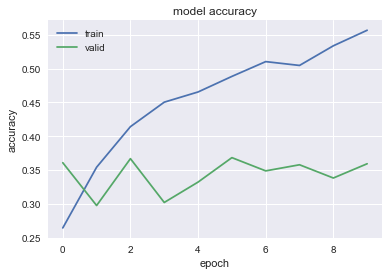

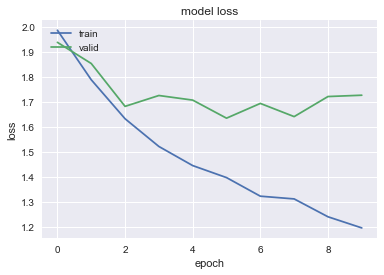

In [33]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [34]:
y_pred = model.predict_proba(test_set)


In [35]:
submission = pd.DataFrame(y_pred)
submission['id'] = test_index
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']
submission.to_csv("submission_all.csv",index=False)
submission.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9,id
0,0.001482,0.337822,0.002916,0.000890,0.011115,0.038528,0.605812,0.000614,0.000821,0
1,0.376954,0.014146,0.013352,0.483639,0.039222,0.049106,0.014447,0.003168,0.005966,1
2,0.490729,0.047300,0.011207,0.263413,0.069213,0.044203,0.067765,0.002419,0.003751,2
3,0.000487,0.250576,0.000554,0.000345,0.001613,0.002583,0.743689,0.000071,0.000082,3
4,0.200132,0.001382,0.003029,0.778008,0.007599,0.006604,0.002484,0.000230,0.000532,4


In [36]:
from keras import backend as K
import seaborn as sns

layer_of_interest=0
intermediate_tensor_function = K.function([model.layers[0].input],[model.layers[layer_of_interest].output])
intermediate_tensor = intermediate_tensor_function([train_set[0,:].reshape(1,-1)])[0]

In [37]:
import matplotlib
colors = list(matplotlib.colors.cnames)

intermediates = []
color_intermediates = []
for i in range(len(train_set)):
    output_class = np.argmax(encoded_y[i,:])
    intermediate_tensor = intermediate_tensor_function([train_set[i,:].reshape(1,-1)])[0]
    intermediates.append(intermediate_tensor[0])
    color_intermediates.append(colors[output_class])

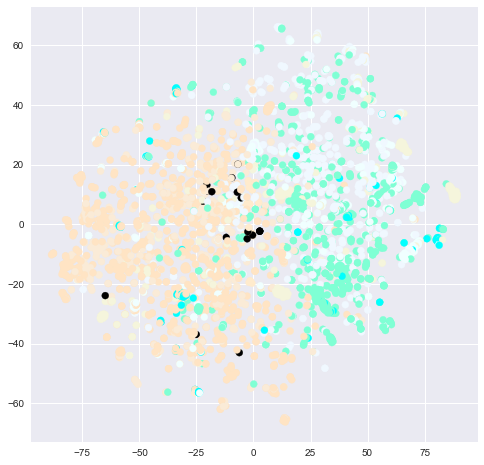

In [38]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
intermediates_tsne = tsne.fit_transform(intermediates)
plt.figure(figsize=(8, 8))
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], color=color_intermediates)
plt.show()